# <center> TP n°3 - Transmission OFDM à IFFT/FFT</center>

<!-- Image dans le même répertoire ![emetteur N mod complexe](images/image_notebook.png) -->

<img src="https://lh3.googleusercontent.com/d/1lRRAjt4RNj0H38nlSAcgGJCLyddyy09G" align=center width="600"> 

### **Objectifs du TP**
Comme on l'a démontré dans le cours, on peut calculer l'enveloppe complexe du signal OFDM $x_{EC-OFDM}(k)$ à partir des symboles de modulations $s_{in}=a_{in}.e^{j.\varphi_{in}}$ associés aux N sous-porteuses pendant un intervalle de temps  $i.T_S< t <(i+1).T_S$ grâce à une iFFT : 

$x_{EC-OFDMi}(k) = \displaystyle \sum_{n=0}^{N-1} s_{in}.e^{ j.2\pi.n.\frac{k}{N}} = iFFT(s_{in})$  


Dans ce TP on travaille donc sur la mise en oeuvre d'une chaîne de transmission OFDM à iFFT/FFT, avec 16 sous-porteuses, toutes les sous-porteuses utilisant une modulation QPSK.

### Import des modules

In [3]:
from commNumv4 import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import importlib

<div class="alert alert-block alert-info">

## I. Emetteur OFDM à iFFT

### 1. Principe de l'architecture de l'émetteur à réaliser
    
    
L'architecture de l'émetteur OFDM à iFFT et les structures de données Python à réaliser sont illustrées ci-dessous (pour 4 sous-porteuses pour simplifier le schéma mais vous utiliserez 16 sous-porteuses dans votre code):  


![emetteur OFDM iFFT](images/emetteur_ifft_fp.png)

L'émetteur comprend les élements suivants :  
- **Conversion série parallèle** avec la fonction numpy `reshape` pour avoir les symboles numériques. On obtient une matrice à 3 dimensions (nombre de symbole OFDM, nombre de sous-porteuses, nombre de bits par symbole)
- **Mapping** pour passer des symboles numériques aux symboles de modulation. On obtient une matrice avec sur chaque ligne l'ensemble des symboles de modulations des sous-porteuses associés à un symbole OFDM. Vous pouvez utiliser la méthode `mapping` de la classe `Ofdm`.
- **zéros padding** qui consiste à insérer des zéros au milieu des symboles de modulation pour augmenter la fréquence d'échantillonnage ici d'un facteur 2 (autant de zéros que de symboles de modulation). Vous pouvez utiliser la méthode `zero_pad` de la classe `Ofdm`.
- **upsampling** permet d'augmenter la fréquence d'échantillonnage du signal pour avoir une fréquence d'échantillonnage suffisante pour la multiplication avec l'exponentielle complexe à la fréquence porteuse de 20KHz . On fera un upsampling d'un facteur 10. Vous utiliserez la fonction `resampled_poly(signal, up, down )`  de scipy qui permet de modifier la fréquence d'échantillonnage d'un facteur $\displaystyle \frac{up}{down}$    
- **FFT** sur chaque ligne de la matrice avec 1 symbole OFDM par ligne pour obtenir l'enveloppe complexe du signal OFDM en parallèle (soit une matrice avec 1 symbole OFDM correspondant à 32 échantillons par ligne)
- **Conversion  parallèle/série** pour avoir l'enveloppe complexe du signal OFDM.
- **upconversion** pour translater l'enveloppe complexe et obtenir le signal OFDM. Vous pouvez utiliser la fonction `upconv` de la classe `Ofdm`.  

L'aide sur chaque fonction de la classe `Ofdm` vous permettra de voir son fonctionnement.
 

</div>

<div class="alert alert-block alert-info bilan">

### 2. Implémentation Python

On souhaite faire une transmission OFDM avec : 
- 16 sous-porteuses
- Une rapidité de modulation R=1000 symboles/s
- Une modulation QPSK pour toutes les sous-porteuses (1+j, ...) 
- 1000 symboles OFDM transmis
- Une fréquence porteuse $f_p=20KHz$

Compléter la cellule de code ci-dessous comprenant les paramètres de la transmission et le code de l'émetteur en vous inspirant du schéma ci-dessus (on prendra le même nommage que sur le schéma).


In [4]:
###############################################
#### Caractéristiques de la transmission #####
###############################################

# Rapidité de modulation et temps symbole
R = 1000
Ts = 1 / R
modulation = 'QPSK'
fp = 20000

# Nombre de sous-porteuses
nb_sp = 16

# Création de l'objet Ofdm et table de mapping QPSK
ofdm = Ofdm()
mapping_table = {
    (0,0): 1+0j,
    (0,1): 0+1j,
    (1,0): -1+0j,
    (1,1): 0-1j
}

# Nombre de symboles de la constellation
M = len(mapping_table)

# Nombre de bits par symbole
nb_bits_symb = int(np.log2(M))

# Nombre de bits par symbole OFDM
nb_bits_ofdm = nb_sp * nb_bits_symb

# Nombre de symbole OFDM
nb_symb_ofdm = 1000

# Nombre de bits à générer
nb_bits = nb_symb_ofdm * nb_bits_ofdm

#####################################################################################
####                        Emetteur  et canal AWGN                              ####
#####################################################################################

# Génération des bits sous forme d'un vecteur
bits = np.random.randint(0, 2, nb_bits)

# Génération des symboles numériques sous forme d'une matrice (nb_symb_ofdm, nb_sp, nb_bits_symb)
symbs_num = bits.reshape(nb_symb_ofdm, nb_sp, nb_bits_symb)

# Génération des symboles OFDM associés à partir des symboles numériques sous forme d'une matrice (nb_symb_ofdm, nb_sp)
symbs_mod = ofdm.mapping(symbs_num, mapping_table)

# Zero padding pour augmenter la fréquence d'échantillonnage d'un facteur 2
symbs_mod_zp = ofdm.zero_pad(symbs_mod, nb_sp)

# Génération de l'enveloppe complexe du signal OFDM à iFFT sous forme d'une matrice
env_ofdm_para = np.fft.ifft(symbs_mod_zp, axis=1)

# Conversion parallèle-série = mis à plat de la matrice avec la fonction numpy ravel
env_ofdm = env_ofdm_para.ravel()

# Upsampling d'un facteur 10
up = 10
down = 1
env_ofdm_up = scipy.signal.resample_poly(env_ofdm, up, down)

# Fréquence d'échantillonnage et upconversion
Fe = (nb_sp * 2) * R * up // down  # 32*1000*10 = 320000 Hz
te = 1 / Fe
signal_ofdm = ofdm.upconv(env_ofdm_up, fp, te)

<div class="alert alert-block alert-info bilan">

### 3. Vérification et analyse

#### 3.1. Bits, symboles numériques, symboles de modulation et zéro padding

1. Afficher les 32 premiers bits et symboles numériques émis.  
<br>

2. Afficher (dans la même cellule) les 16 premiers symboles numériques émis.  
<br>
 
3. Afficher les 16 premiers symboles de modulation correpsondant au premier symbole OFDM.  
<br>

4. Afficher les 16 premiers symboles de modulation après 0 padding.  
<br>
5. Sachant qu'il y a 16 échantillons (16 symboles de modulation)par temps symbole, en déduire la fréquence d'échantillonnage avant zero-padding.  
<br>
6. Sachant qu'il y a 32 échantillons (16 symboles de modulation et 16 zéros) par temps symbole, en déduire la fréquence d'échantillonnage en sortie du bloc zero-padding.  

</div>

In [5]:
# 1. Afficher les 32 premiers bits et symboles numériques émis
print('Bits émis (32 premiers):')
print(bits[:32])

print('\nSymboles numériques émis (32 premiers):')
print(symbs_num.reshape(-1, nb_bits_symb)[:32])

# 2. Afficher les 16 premiers symboles numériques émis
print('\nSymboles numériques émis (16 premiers):')
print(symbs_num.reshape(-1, nb_bits_symb)[:16])

# 3. Afficher les 16 premiers symboles de modulation du premier symbole OFDM
print('\nSymboles de modulation du 1er symbole OFDM:')
print(symbs_mod[0, :])

# 4. Afficher les 16 premiers symboles de modulation après zero padding (1er symbole OFDM)
print('\nSymboles de modulation après zero padding (1er symbole OFDM, 32 premiers):')
print(symbs_mod_zp[0, :])

# 5. Fréquence d'échantillonnage avant zero-padding
Fe_avant_zp = nb_sp * R
print(f'\nFréquence d\'échantillonnage avant zero-padding : {Fe_avant_zp} Hz')

# 6. Fréquence d'échantillonnage après zero-padding
Fe_apres_zp = (nb_sp * 2) * R
print(f'Fréquence d\'échantillonnage après zero-padding : {Fe_apres_zp} Hz')

Bits émis (32 premiers):
[1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0]

Symboles numériques émis (32 premiers):
[[1 1]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]]

Symboles numériques émis (16 premiers):
[[1 1]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]

Symboles de modulation du 1er symbole OFDM:
[ 0.-1.j  0.+1.j  0.-1.j  0.+1.j  0.-1.j  0.+1.j  0.+1.j  1.+0.j  1.+0.j
 -1.+0.j  0.+1.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]

Symboles de modulation après zero padding (1er symbole OFDM, 32 premiers):
[ 0.-1.j  0.+1.j  0.-1.j  0.+1.j  0.-1.j  0.+1.j  0.+1.j  1.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j -1.+0.j  0.+1.j
 -1.+0.j  1.+0.j  

<div class="alert alert-block alert-danger travail">
        
**Réponses aux questions 5 et 6**:


</div>

<div class="alert alert-block alert-info bilan">

#### 3.2. DSP de l'enveloppe complexe OFDM

  
On souhaite visualiser la DSP de l'enveloppe complexe du signal OFDM sans et avec zéro padding et la DSP du signal OFDM.  


1. Dans une nouvelle cellule de code, calculer l'enveloppe complexe du signal OFDM sans zero padding (ifft et mise à plat avec la fonction ravel()).  
<br>

2. A l'aide de la méthode statique dsp de la classe Mesure, visualiser la DSP de l'enveloppe complexe sans et avec zero padding et la DSP du signal OFDM. Vous commencerez par calculer les fréquences d'échantillonnage pour l'enveloppe complexe sans et avec zero padding.  
<br>

3. Commenter les résultats.

</div>

DSP enveloppe complexe sans zero padding:


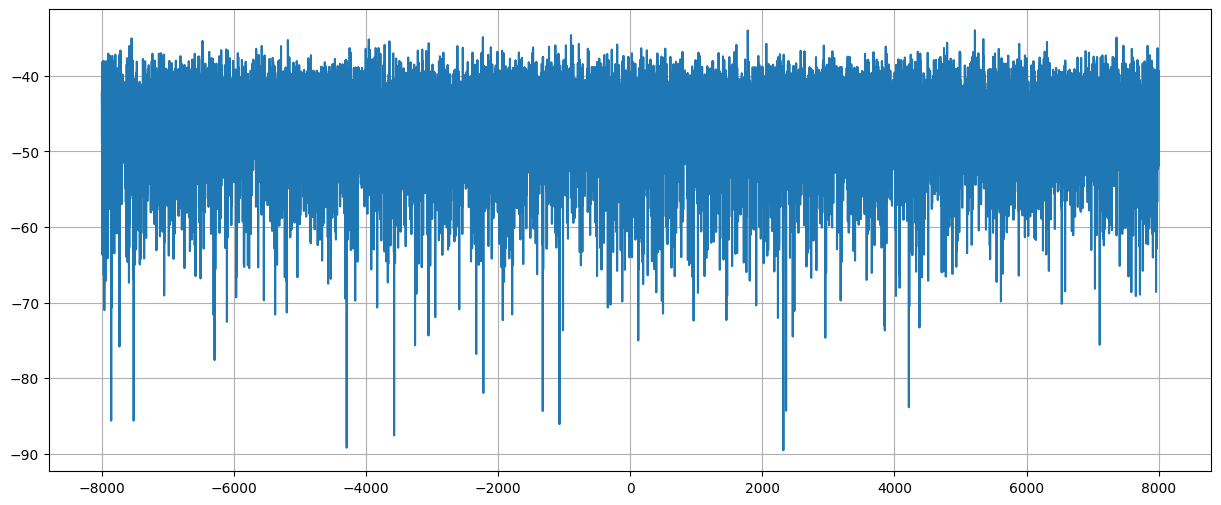

DSP enveloppe complexe avec zero padding:


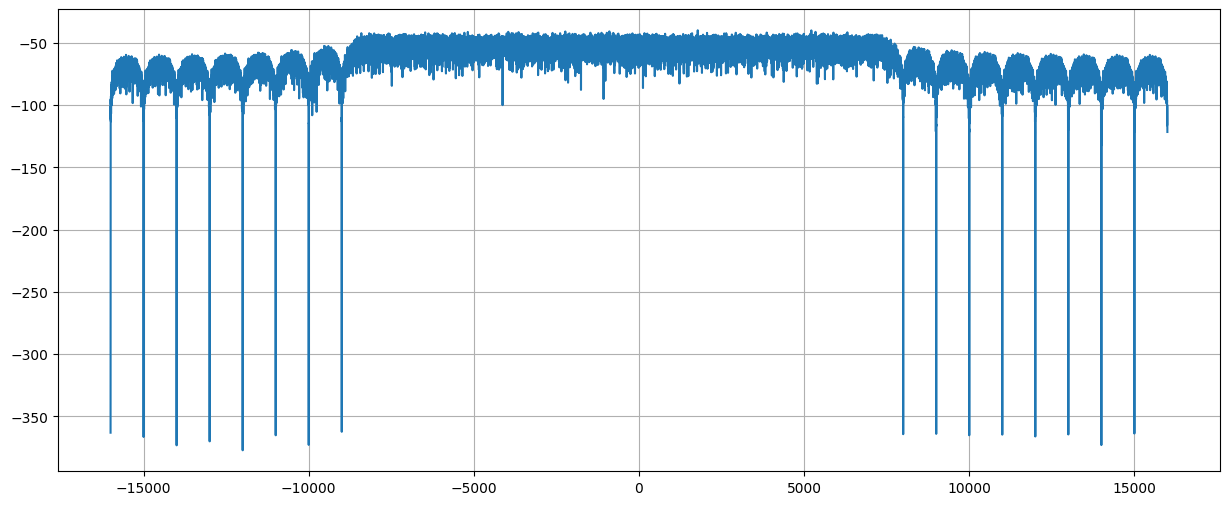

DSP du signal OFDM (après upconversion):


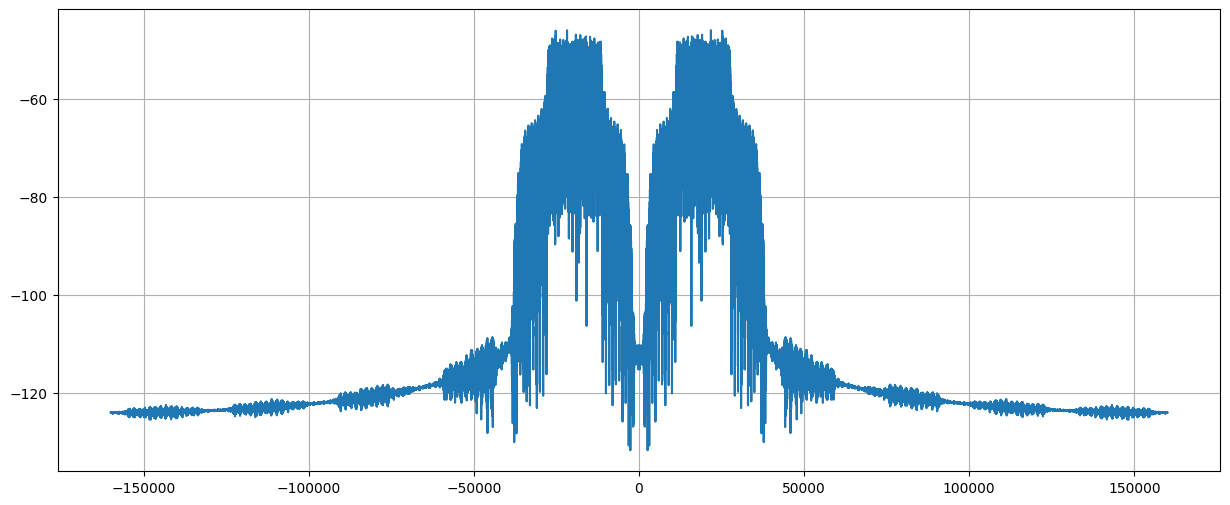

(array([-160000., -159999., -159998., ...,  159997.,  159998.,  159999.],
       shape=(320000,)),
 array([-124.06023885, -124.06024223, -124.06023938, ..., -124.06023823,
        -124.06023938, -124.06024223], shape=(320000,)))

In [ ]:
# 1. Enveloppe complexe du signal OFDM sans zero padding
env_ofdm_para_nozp = np.fft.ifft(symbs_mod, axis=1)
env_ofdm_nozp = env_ofdm_para_nozp.ravel()

# 2. Visualisation des DSP
Fe_nozp = nb_sp * R  # 16*1000 = 16000 Hz
Fe_zp = (nb_sp * 2) * R  # 32*1000 = 32000 Hz

print('DSP enveloppe complexe sans zero padding:')
Mesure.dsp(env_ofdm_nozp, Fe_nozp)

print('DSP enveloppe complexe avec zero padding:')
Mesure.dsp(env_ofdm, Fe_zp)

print('DSP du signal OFDM (après upconversion):')
Mesure.dsp(signal_ofdm, Fe)

<div class="alert alert-block alert-danger travail">

**Commentaires sur les résultats**


    
 </div>

<div class="alert alert-block alert-info bilan">

#### 3.2. Allure temporelle du signal OFDM

  
Visualiser l'allure temporelle du signal OFDM sur 5 temps symboles (soit 5ms).  

<div>

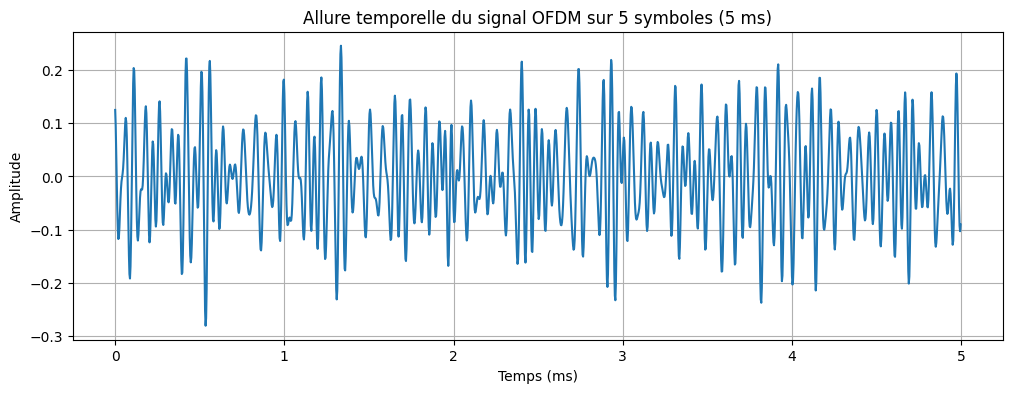

In [7]:
# Visualisation de l'allure temporelle du signal OFDM sur 5 temps symboles (5 ms)
nb_ech_5symb = int(Fe * 5 * Ts)  # 5 symboles OFDM
t = np.arange(nb_ech_5symb) / Fe * 1e3  # en ms
plt.figure(figsize=(12,4))
plt.plot(t, signal_ofdm[:nb_ech_5symb])
plt.xlabel('Temps (ms)')
plt.ylabel('Amplitude')
plt.title('Allure temporelle du signal OFDM sur 5 symboles (5 ms)')
plt.grid()
plt.show()


<div class="alert alert-block alert-success">
        
## II. Canal AWGN et récepteur OFDM à FFT

### 1. Canal AWGN
    
Pour simuler un canal AWGN, rajouter un bruit blanc gaussien d'espérance nulle et d'écart type 0.05. Vous pouvez utiliser la classe Canal.  
    
</div>

In [9]:
#####################################################################################
####                               Canal AWGN                                    ####
#####################################################################################

# Ajout d'un bruit blanc gaussien d'espérance nulle et d'écart type 0.05
signal_ofdm_bruite = Canal.awgn(signal_ofdm, mean=0, std=0.05)

<div class="alert alert-block alert-info bilan">

### 2. Principe de l'architecture du récepteur à réaliser
    
L'architecture du récepteur OFDM à FFT (pour 4 sous-porteuses) est illustré ci-dessous : 
    
<br>

![emetteur OFDM iFFT](images/recepteur_ifft_fp.png)

Le récepteur comprend les élements suivants qui implémentent globalement les fonctions inverses de l'émetteur :
- **Downconversion** pour translater le signal OFDM en bande de base et retrouver l'enveloppe complexe. Vous pouvez utiliser la fonction `downconv_filt` de la classe `Ofdm` qui translate de filtre passe-bas pour enlever à la composante spectrale à $-2.f_P$.
- **Downsampling** pour avoir 32 échantillons par symbole OFDM. Comme on avait upsampler d'un facteur 10 en émission, il faudra downsampler du même facteur. Vous pouvez utiliser la fonction `resampled_poly`  de scipy.
- **Conversion série / parallèle** pour avoir une matrice avec 1 symbole OFDM par ligne soit ici 32 échantillons par ligne.
- **FFT** sur chaque ligne pour retrouver les symboles de modulation : 16 symboles de modulation associés aux sous-porteuses et 16 zéros (soit 32 échantillons comme en entrée de la FFT)
- **Suppression des zéros** pour ne garder que les 16 symboles de modulation des sous-porteuses. Vous pouvez utiliser la méthode `rem_zero_pad` de la classe `Ofdm`.
- **Conversion parallèle série** pour retrouver les symboles de modulation en série 
- **Détection** en faisant un calcul de distance avec la fonction min pour décider du symbole le plus probablement émis. Vous pouvez utiliser la méthode `detection` de la classe `Ofdm`.
- **Démapping** pour repasser des symboles de modulation aux bits. Vous pouvez utiliser la méthode `demapping` de la classe `Ofdm`.

L'aide sur chaque fonction de la classe `Ofdm` vous permettra de voir le fonctionnement de chaque fonction.

**Remarque** : La FFT doit être prise sur chaque symbole OFDM de l'enveloppe complexe comme illustré ci-dessous :

![FFT OK](images/ec_rcv_fft_ok.png)

Si le récepteur introduit un décalage/retard, les FFT ne seront pas prises sur les bons échantillons et les symboles reçus seront totalement faux :

![FFT OK](images/ec_rcv_fft_nok.png)

 
 La fonction utilisée pour filtrer dans la downconversion est donc `filtfilt` qui n'introduit pas de retard.

</div>

<div class="alert alert-block alert-info bilan">

### 3. Implémentation Python

Compléter la cellule de code commentée ci-dessous pour réaliser le récepteur.

In [10]:
#####################################################################################
####                                Récepteur                                    ####
#####################################################################################

# Downconversion et filtrage pour obtenir l'enveloppe complexe reçue
fc = Fe // 4  # fréquence de coupure du filtre passe-bas (par exemple 1/4 de Fe)
env_ofdm_rcv = Ofdm.downconv_filt(signal_ofdm_bruite, fp, te, fc)

# Downsampling (d'un facteur 10, comme l'upsampling à l'émission)
env_ofdm_rcv_down = scipy.signal.resample_poly(env_ofdm_rcv, down, up)

# Conversion série-parallèle : matrice (nb_symb_ofdm, 32)
env_ofdm_rcv_para = env_ofdm_rcv_down.reshape(nb_symb_ofdm, nb_sp*2)

# Passage de l'enveloppe complexe aux symboles de modulation avec une FFT
symbs_rcv_zp = np.fft.fft(env_ofdm_rcv_para, axis=1)

# Suppression du zéro padding
symbs_rcv_para = Ofdm.rem_zero_pad(symbs_rcv_zp, nb_sp)

# Conversion parallèle-série : mise à plat de la matrice
symbs_rcv = symbs_rcv_para.ravel()

# Détection
symbs_detect = Ofdm.detection(symbs_rcv, mapping_table)

# Demapping
bits_rcv = Ofdm.demapping(symbs_detect, mapping_table)

<div class="alert alert-block alert-info bilan">

### 4. Vérification et analyse

#### 4.1. Bits émis et reçus

Vérifier que les 32 premiers bits émis et reçus sont les mêmes.

In [13]:
print('Bits émis (32 premiers):')
print(bits[:32])

print('\nBits reçus (32 premiers):')
print(bits_rcv[:32])

print("Taux d'erreur binaire (TEB):")
teb = np.sum(bits != bits_rcv) / len(bits)
print(teb)

Bits émis (32 premiers):
[1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0]

Bits reçus (32 premiers):
[1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0]
Taux d'erreur binaire (TEB):
0.0


#### 4.2. Enveloppe complexe reçue

Visualiser l'enveloppe complexe reçue avant downsampling (partie réelle et imaginaire sur le même graphique) et sa DSP.

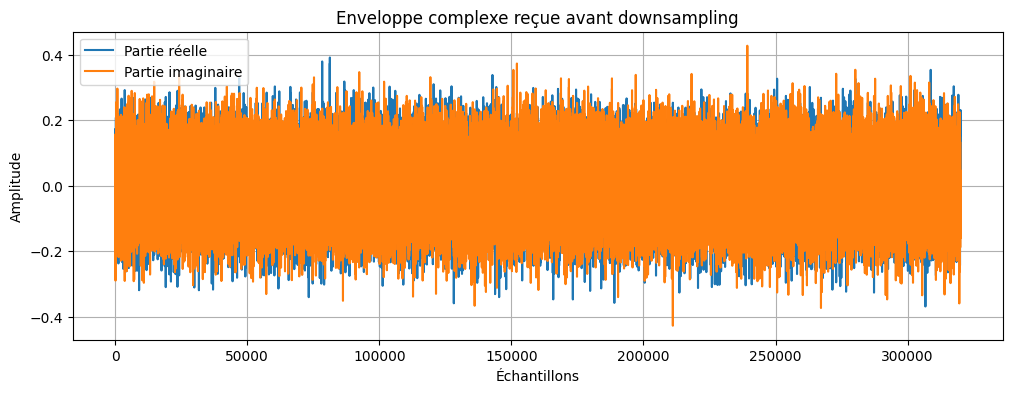

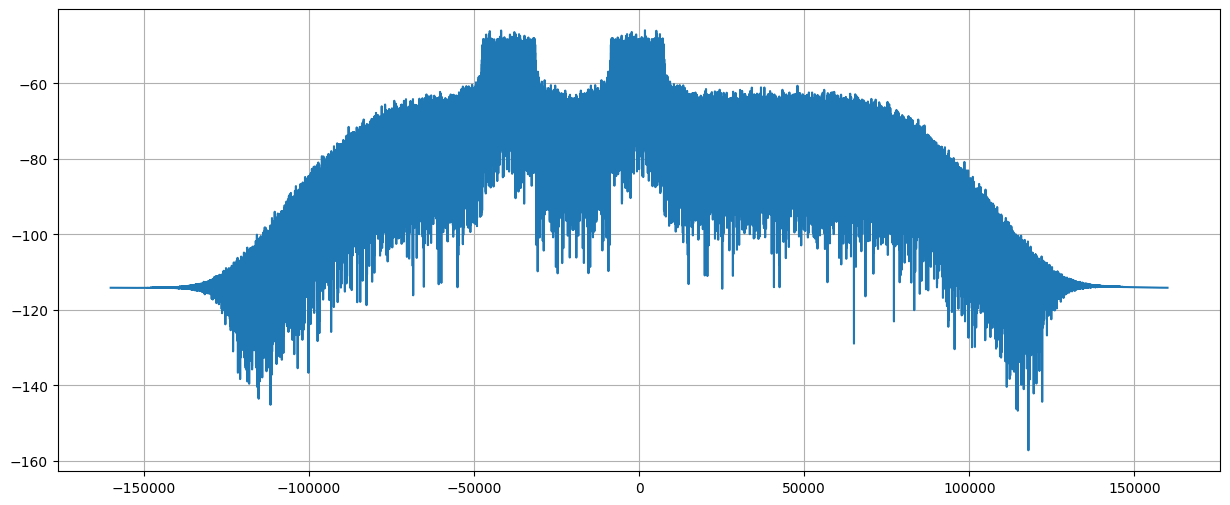

(array([-160000., -159999., -159998., ...,  159997.,  159998.,  159999.],
       shape=(320000,)),
 array([-114.13300477, -114.13301272, -114.13302066, ..., -114.13298094,
        -114.13298889, -114.13299683], shape=(320000,)))

In [14]:
# Visualisation de l'enveloppe complexe reçue avant downsampling
plt.figure(figsize=(12,4))
plt.plot(np.real(env_ofdm_rcv), label='Partie réelle')
plt.plot(np.imag(env_ofdm_rcv), label='Partie imaginaire')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')
plt.title('Enveloppe complexe reçue avant downsampling')
plt.legend()
plt.grid()
plt.show()

# DSP de l'enveloppe complexe reçue avant downsampling
Mesure.dsp(env_ofdm_rcv, Fe)

<div class="alert alert-block alert-info bilan">

#### 4.3. Diagramme de constallation des sous-porteuses

La fonction `symbs_ofdm_to_sp` de la classe `Ofdm` permet de récuperer les symboles de modulation de chaque sous-porteuse sur une même ligne. Elle prend en entrée la matrice avec un symbole OFDM par ligne (`symbs_rcv_para` dans la chaîne de réception de dimension (1000,16)) et retourne un tableau avec l'ensemble des symboles de modulation d'un sous-porteuse sur une même ligne (on aura ici une matrice de dimension (16, 1000)). Cette fonction nous permettra alors de tracer le diagramme de constellation des sous-porteuses avec la fonction `plot_constel_sp`.  
    
    
1. A l'aide de ces 2 fonctions de la classe `Ofdm`, visualiser le diagramme de constellation des sous-porteuses.  
<br>
    
2. Commenter le résultat obtenu et conclure sur l'intérêt de l'émetteur/récepteur OFDM à iFFT/FFT par rapport à celui à N modulateurs/démodulateurs complexes.
  
</div>

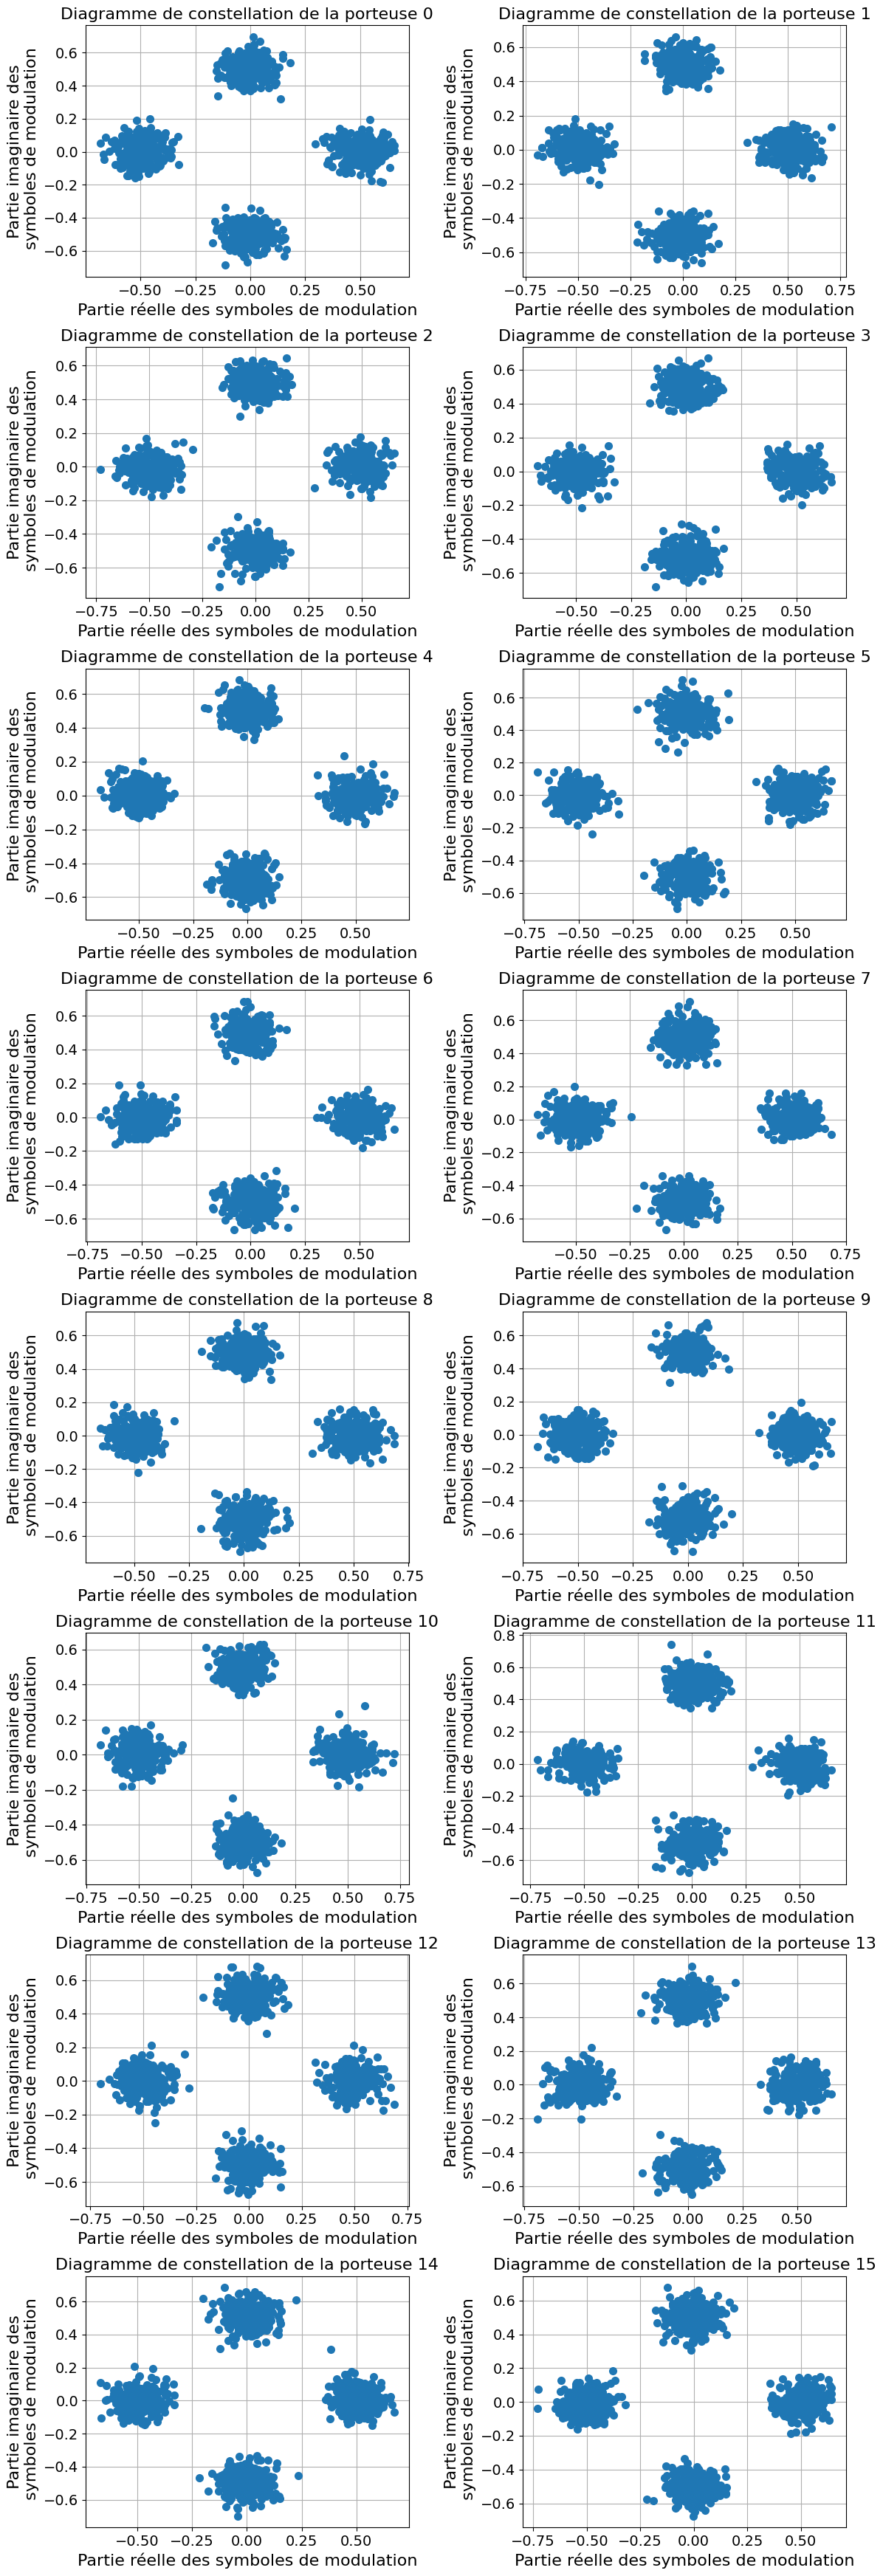

In [15]:
# Diagramme de constellation des sous-porteuses
symbs_sp = Ofdm.symbs_ofdm_to_sp(symbs_rcv_para)
Ofdm.plot_constel_sp(symbs_sp)

**Commentaires**

